In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [60]:
img_width, img_height = 224, 224

In [61]:
IMAGE_SIZE=224
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [62]:
base_model=ResNet50(weights='imagenet',include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [41]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [42]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("train 1",shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 3208 files belonging to 20 classes.


In [43]:
class_names=dataset.class_names
class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT']

In [44]:
len(dataset)

101

In [45]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(32, 224, 224, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 8, 16,  4,  3, 12,  2, 18,  0,  1, 12,  7,  8, 12,  6, 13, 13,  2,
       10,  9,  9,  0,  4,  2,  7, 16, 14, 15,  3, 16,  8, 15, 13])>>


In [46]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[139. 167. 106.]
  [155. 184. 120.]
  [165. 190. 125.]
  ...
  [118. 152.   3.]
  [116. 151.   0.]
  [116. 151.   0.]]

 [[137. 162. 107.]
  [147. 172. 115.]
  [156. 180. 122.]
  ...
  [116. 150.   1.]
  [114. 149.   0.]
  [113. 148.   0.]]

 [[135. 156. 113.]
  [140. 158. 116.]
  [148. 166. 124.]
  ...
  [113. 147.   0.]
  [110. 146.   0.]
  [109. 145.   0.]]

 ...

 [[106. 118.  46.]
  [129. 144.  63.]
  [147. 167.  70.]
  ...
  [159. 163.  78.]
  [147. 154.  58.]
  [136. 144.  43.]]

 [[ 97. 109.  33.]
  [129. 144.  59.]
  [151. 172.  69.]
  ...
  [158. 165.  72.]
  [150. 158.  59.]
  [141. 149.  46.]]

 [[ 91. 104.  25.]
  [127. 143.  55.]
  [150. 171.  66.]
  ...
  [154. 161.  66.]
  [150. 158.  57.]
  [143. 151.  48.]]], shape=(224, 224, 3), dtype=float32)


<ipython-input-47-6f5c52dfb154>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,4,i+1)


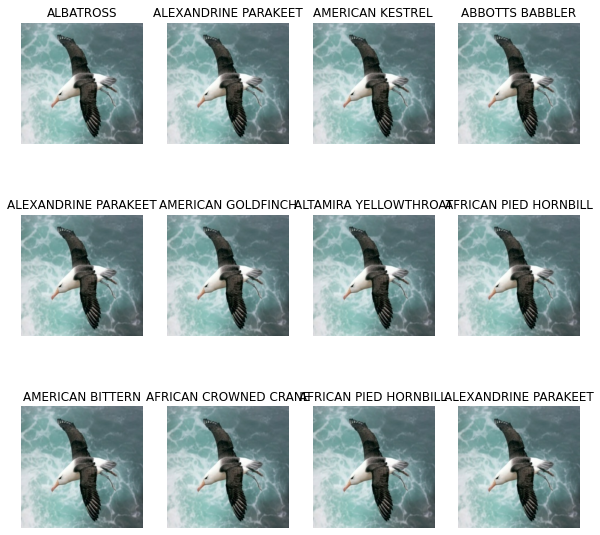

In [47]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(3):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [48]:
train_size=0.8
len(dataset)*train_size

80.80000000000001

In [49]:
train_ds=dataset.take(1766)
train_ds
len(train_ds)

101

In [50]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split *ds_size)
    val_size=int(val_split *ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds
len(train_ds)

101

In [51]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [52]:
len(train_ds)

80

In [53]:
len(val_ds)

10

In [54]:
len(test_ds)

11

In [55]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [56]:
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [57]:
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [65]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/224)
])

In [66]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [67]:
for layer in base_model.layers:
    layer.trainable = False

In [68]:
last_layer = base_model.get_layer('conv5_block3_out')
print(last_layer.output_shape)

(None, 7, 7, 2048)


In [69]:
x = Flatten()(last_layer.output)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(20, activation = 'softmax')(x)
model = Model(base_model.input, x)

In [70]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [71]:
optimizer = Adam(lr=1e-6)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [72]:
history = model.fit_generator(train_ds,
                    steps_per_epoch=80,
                    epochs = 50,
                    validation_data = val_ds,
                    validation_steps = 10)

D:\Softwares\python\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x000001F2824DA1F0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x000001F282

In [73]:
score= model.evaluate(test_ds)

11/11 [==============================] - 85s 2s/step - loss: 0.1074 - accuracy: 0.9659


In [74]:
score

[0.10739293694496155, 0.9659090638160706]

In [75]:
history

In [76]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 80}

In [77]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [78]:
acc=history.history['accuracy']
val_acc =history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

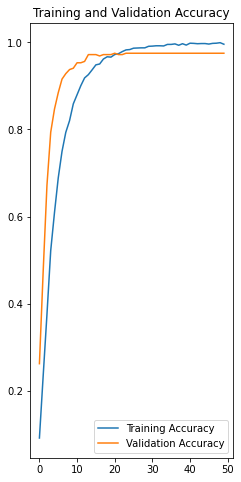

In [79]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

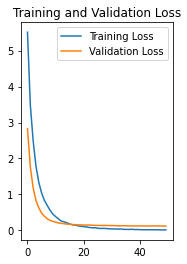

In [80]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [81]:
for image_batch,labels_batch in test_ds.take(1):
    
    print(image_batch[0].numpy())

[[[246. 240. 216.]
  [205. 199. 175.]
  [142. 131. 113.]
  ...
  [108.  77.  48.]
  [102.  71.  43.]
  [ 97.  66.  38.]]

 [[246. 240. 216.]
  [209. 203. 181.]
  [140. 132. 113.]
  ...
  [109.  78.  49.]
  [104.  73.  45.]
  [ 99.  68.  40.]]

 [[246. 241. 219.]
  [216. 210. 188.]
  [141. 133. 114.]
  ...
  [111.  80.  51.]
  [107.  76.  47.]
  [103.  72.  43.]]

 ...

 [[ 37.  28.   0.]
  [ 52.  41.  11.]
  [ 54.  37.   7.]
  ...
  [ 40.  34.  20.]
  [ 36.  30.  18.]
  [ 38.  32.  20.]]

 [[ 56.  41.  10.]
  [ 64.  48.  15.]
  [ 76.  51.  20.]
  ...
  [ 39.  35.  24.]
  [ 38.  31.  21.]
  [ 40.  33.  23.]]

 [[ 71.  55.  22.]
  [ 83.  63.  30.]
  [ 96.  67.  37.]
  ...
  [ 40.  36.  25.]
  [ 41.  34.  26.]
  [ 45.  38.  30.]]]


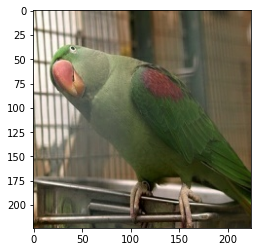

In [82]:
for image_batch,labels_batch in test_ds.take(1):
    
    plt.imshow(image_batch[0].numpy().astype('uint8'))

first image to predict
actual label: AMERICAN PIPIT
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[3.0865180e-04 9.4720343e-07 5.0835564e-07 8.5443571e-06 8.9821633e-06
 1.1194609e-04 2.9178744e-07 1.1475773e-06 2.0892830e-06 1.1966971e-02
 2.7042643e-06 7.2802133e-05 1.8939445e-05 3.0131216e-04 1.7193244e-05
 2.4414109e-04 3.9048437e-06 4.5093042e-05 3.4412

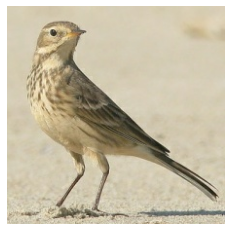

In [83]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

In [84]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

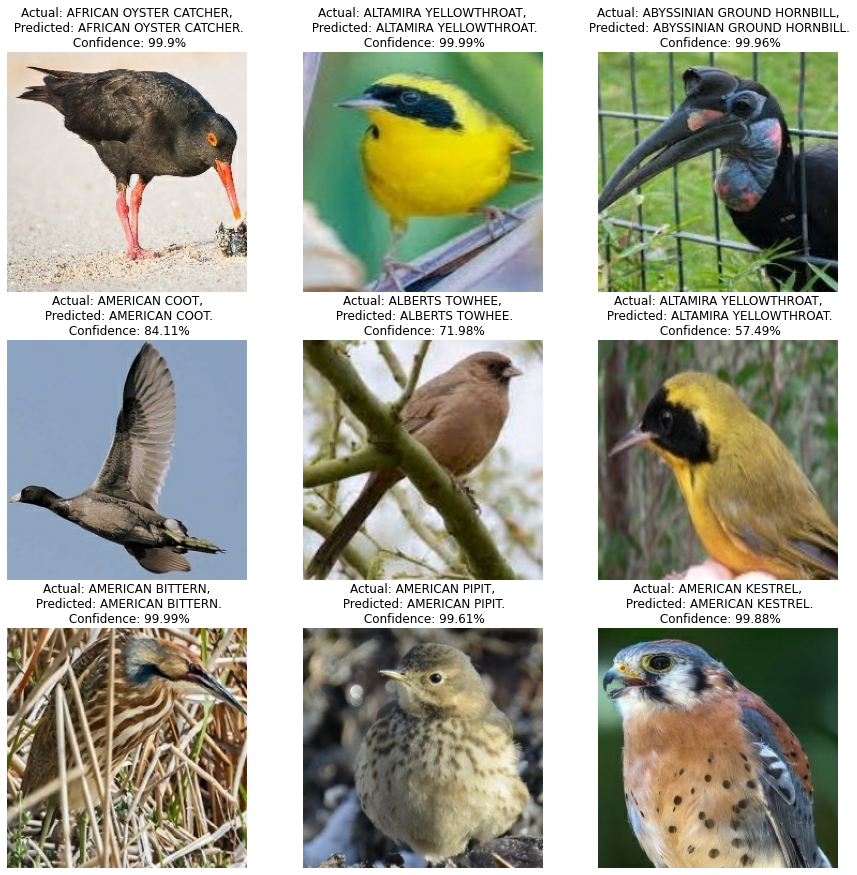

In [85]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [87]:
import os
model_version=max([int(i) for i in os.listdir("./model1") + [0]])+1
model.save(f"./model1/{model_version}")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ./model1/1\assets
